# Ensemble Final Modeling

In [3]:
# Import libraries
import pandas as pd
import numpy as np

In [4]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [5]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [6]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [7]:
y_train = train['rating_category']
y_test = test['rating_category']

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [9]:
# Encode y_test
y_test_encoded = le.transform(y_test)

In [10]:
import joblib

# Load the models
loaded_logistic_model = joblib.load('/content/drive/MyDrive/data/logreg_vt_model.pkl')
loaded_rf_model = joblib.load('/content/drive/MyDrive/data/rf_vt_model.pkl')
loaded_xgb_model = joblib.load('/content/drive/MyDrive/data/xgboost_vt_model.pkl')


In [11]:
# Double checking our models
test_score_logistic = loaded_logistic_model.score(X_test, y_test)
test_score_rf = loaded_rf_model.score(X_test, y_test)
test_score_xgb = loaded_xgb_model.score(X_test, y_test_encoded)

print(f'Logistic Regression Test Accuracy: {test_score_logistic}')
print(f'Random Forest Test Accuracy: {test_score_rf}')
print(f'XGBoost Test Accuracy: {test_score_xgb}')


Logistic Regression Test Accuracy: 0.639601885804086
Random Forest Test Accuracy: 0.6225772655840754
XGBoost Test Accuracy: 0.6094814038763751


In [28]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Initialize individual models with the loaded models
logistic_model = loaded_logistic_model
rf_model = loaded_rf_model
xgb_model = loaded_xgb_model

# Create an ensemble of the models using a majority class voting strategy
ensemble_model = VotingClassifier(estimators=[('lr', logistic_model), ('rf', rf_model), ('xgb', xgb_model)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train_encoded)

# Evaluate the ensemble on the test set
ensemble_score = ensemble_model.score(X_test, y_test_encoded)

print(f'Voting Classifier Test Accuracy: {ensemble_score}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Voting Classifier Test Accuracy: 0.6561026715557884


In [34]:
# Make predictions
y_pred_voting = ensemble_model.predict(X_test)
y_score_voting = ensemble_model.predict_proba(X_test)

# Getting class labels
class_labels = ensemble_model.classes_

In [37]:
# Generate Classification Report

# Decode the  class labels
decoded_class_labels = le.inverse_transform([0, 1, 2, 3])

# classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test_encoded, y_pred_voting, target_names=decoded_class_labels))

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

     Average       0.56      0.50      0.52      1899
   Excellent       0.76      0.76      0.76      1762
        Good       0.55      0.58      0.56      1980
        Poor       0.76      0.79      0.78      1995

    accuracy                           0.66      7636
   macro avg       0.66      0.66      0.66      7636
weighted avg       0.65      0.66      0.65      7636



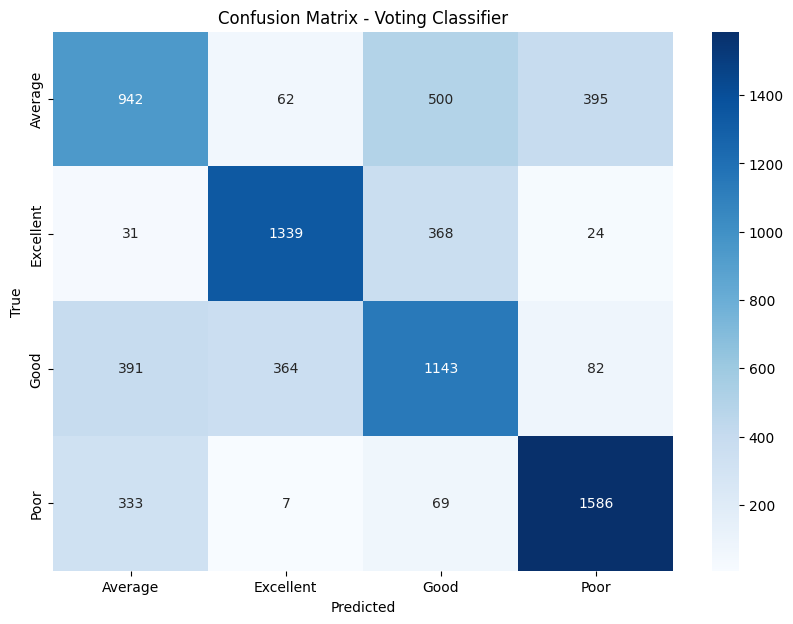

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm_voting = confusion_matrix(y_test_encoded, y_pred_voting)

# Using seaborn to make the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_voting, annot=True, fmt='g', cmap="Blues",
            xticklabels=decoded_class_labels, yticklabels=decoded_class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
# Initialize the Stacking Classifier with the individual models and a logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[('lr', loaded_logistic_model), ('rf', loaded_rf_model), ('xgb', loaded_xgb_model)],
    final_estimator=LogisticRegression()
)

# Fit the stacking classifier
stacking_model.fit(X_train, y_train_encoded)

# Evaluate the model
stacking_score = stacking_model.score(X_test, y_test_encoded)

print(f'Stacking Classifier Test Accuracy: {stacking_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Stacking Classifier Test Accuracy: 0.6616029334730226


In [22]:
# Make predictions
y_pred_stacking = stacking_model.predict(X_test)
y_score_stacking = stacking_model.predict_proba(X_test)

# Getting class labels
class_labels = stacking_model.classes_

In [31]:
# Generate Classification Report

# Decode the  class labels
decoded_class_labels = le.inverse_transform([0, 1, 2, 3])

# classification report
print("Classification Report for Stacking Classifier:")
print(classification_report(y_test_encoded, y_pred_stacking, target_names=decoded_class_labels))

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

     Average       0.54      0.56      0.55      1899
   Excellent       0.77      0.75      0.76      1762
        Good       0.55      0.58      0.57      1980
        Poor       0.80      0.76      0.78      1995

    accuracy                           0.66      7636
   macro avg       0.67      0.66      0.67      7636
weighted avg       0.67      0.66      0.66      7636



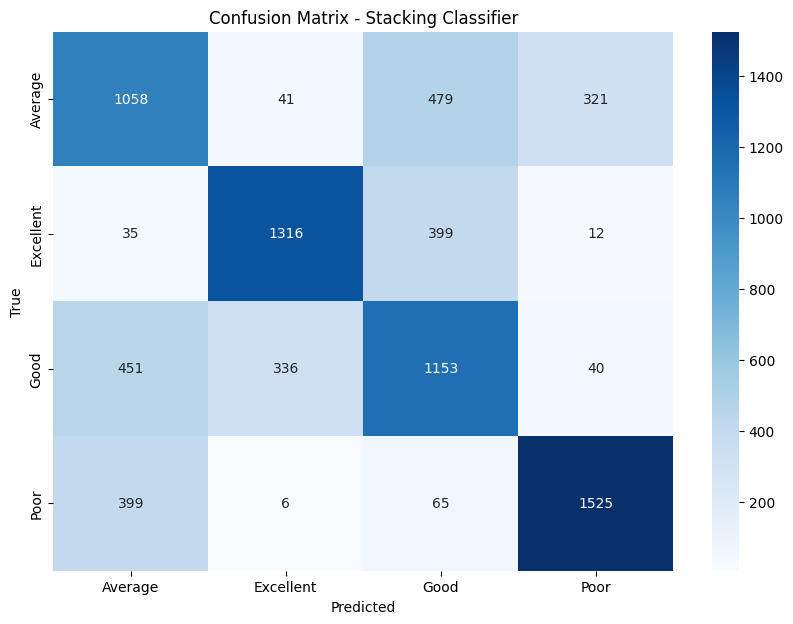

In [48]:
# Confusion Matrix
cm_stacking = confusion_matrix(y_test_encoded, y_pred_stacking)

# Using seaborn to make the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_stacking, annot=True, fmt='g', cmap="Blues",
            xticklabels=decoded_class_labels, yticklabels=decoded_class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()